In [1]:

import pandas as pd 

In [3]:
df = pd.read_csv(r"C:\Users\User\Desktop\프로젝트\개인\instacart_feedback\민지\instacart_rvw_all_trans.csv")

In [4]:

df.rename(columns={'리뷰(번역)': '리뷰'}, inplace=True)

In [5]:
df.head(3)

,rating,review,리뷰
0,1,The two times I have ordered and had my delive...,내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다. 어떤 이...
1,1,I have ordered 6 times using Instacart and 4 o...,"인스타카트를 통해 6번 주문했고, 그 중 4번이 문제가 있었습니다. 이번에 주문을 ..."
2,1,8 times out of 10 was terrible experience.\nLa...,10번 중 8번은 최악의 경험이었습니다. 마지막으로 쇼퍼가 아이스크림 3상자를 쿨한...


In [8]:
#'리뷰' 컬럼 문장분리 
import re
# 문장 단위로 분리 → explode로 행 나누기
df['sentences'] = df['리뷰'].apply(lambda x: re.split('[.!?]', x))  # 문장 단위 나누기
df = df.explode('sentences')  # 문장별로 나누기
df['sentences'] = df['sentences'].str.strip()  # 공백 제거
df = df[df['sentences'].str.len() > 3]  # 너무 짧은 문장 제거

In [9]:
# 문장 분리 결과 확인
df[['rating', 'sentences']].head(3)

,rating,sentences
0,1,내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다
0,1,어떤 이유로 인해 앱의 매핑이 운전자를 완전히 다른 도시로 보냈습니다
0,1,운전자에게 메시지를 보내서 GPS를 사용하여 건물을 찾도록 요청했습니다 (실제 시청...


In [14]:
#KoNLPy의 Okt 형태소 분석기를 활용하여 문장(sentences)을 
# 형태소 분석 + 불용어 제거 + 주요 품사 필터링하는 전처리 과정
from konlpy.tag import Okt

okt = Okt()

# 불용어 예시
stopwords = ['정말', '진짜', '너무', '거의', '그냥', '좀', '것', '거', '에서', '으로', '하게', '해서']

# 토큰화 및 불용어 제거
def clean_and_tokenize(text):
    tokens = okt.pos(text, stem=True)  # 품사 정보 포함
    cleaned = [word for word, tag in tokens 
               if tag in ['Noun', 'Adjective'] and word not in stopwords]
    return cleaned

df['tokens_LDA'] = df['sentences'].apply(clean_and_tokenize)

-> LDA는 텍스트의 의미적인 흐름을 잡아내는 모델이라 명사와 형용사가 같이 포함되어야 자연스러운 주제나옴 

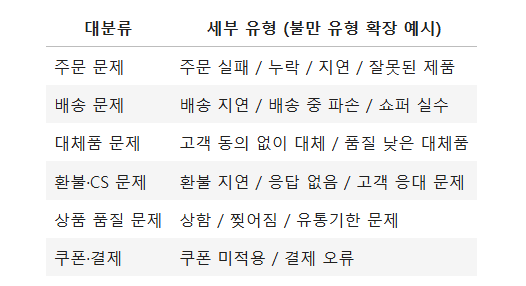

In [16]:
from konlpy.tag import Okt
okt = Okt()

def clean_and_tokenize(text):
    # 예시: 명사 추출 + 불용어 제거
    stopwords = ['정말', '진짜', '너무', '거의', '그냥', '좀', '것', '거', '에서', '으로', '하게', '해서']
    tokens = okt.nouns(text)
    tokens = [word for word in tokens if word not in stopwords and len(word) > 1]
    return tokens

# 적용
df['tokens_cluster'] = df['리뷰'].apply(clean_and_tokenize)
from konlpy.tag import Okt
okt = Okt()
def tokenize(text):
    return [w for w, pos in okt.pos(text) if pos in ['Noun']]

-> 클러스터 분석(kmeans,pca)에서는 TF-IDF 벡터화를 수치화해서 거리 기반으로 분석하는게 더 명확한 구분을 만들어냄 
- 형용사, 동사는 의미의 분산을 키우기때문에 제외하고 명사만 잡은거

|대분류	      |세부 유형 (불만 유형 확장 예시)|
주문 문제     |	주문 실패 / 누락 / 지연 / 잘못된 제품 |
배송 문제     |	배송 지연 / 배송 중 파손 / 쇼퍼 실수  |
대체품 문제   |	고객 동의 없이 대체 / 품질 낮은 대체품 |
환불·CS 문제  |	환불 지연 / 응답 없음 / 고객 응대 문제 |
상품 품질 문제|	상함 / 찢어짐 / 유통기한 문제          |
쿠폰·결제     |	쿠폰 미적용 / 결제 오류                |



df_filtered = df[df['filtered_tokens'].apply(lambda x: len(x) > 2)].copy() 
- 이전에는 모르고 이거 하나로 필터링했지만 
LDA와 클러스터 둘다 고려해서 필터링해야함 

In [19]:
df_filtered = df[
    (df['tokens_cluster'].apply(lambda x: len(x) > 2)) &
    (df['tokens_LDA'].apply(lambda x: len(x) > 2))
].copy()

In [22]:
# 전체 리뷰 수
print("전체 리뷰 수:", len(df))

# LDA용 필터링
df_lda = df[df['tokens_LDA'].apply(lambda x: len(x) >= 2)].copy()
print("LDA 전처리 후 리뷰 수:", len(df_lda))
print("LDA 필터링 비율:", round(100 - len(df_lda)/len(df)*100, 2), "%")

# 클러스터링용 필터링
df_cluster = df[df['tokens_cluster'].apply(lambda x: len(x) >= 2)].copy()
print("클러스터링 전처리 후 리뷰 수:", len(df_cluster))
print("클러스터링 필터링 비율:", round(100 - len(df_cluster)/len(df)*100, 2), "%")


전체 리뷰 수: 68744
LDA 전처리 후 리뷰 수: 65422
LDA 필터링 비율: 4.83 %
클러스터링 전처리 후 리뷰 수: 68744
클러스터링 필터링 비율: 0.0 %


In [28]:
from gensim import corpora
from gensim.models import LdaModel

# 1. 전처리된 텍스트 리스트 사용
texts = df_lda['tokens_LDA'].tolist()

# 2. 사전(dictionary) 생성
dictionary = corpora.Dictionary(texts)

# 3. 코퍼스(corpus) 생성 (Bag-of-Words 형태)
corpus = [dictionary.doc2bow(text) for text in texts]

# 4. LDA 모델 학습
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=10
)

# 5. 문서별 토픽 벡터 추출
lda_vectors = [
    lda_model.get_document_topics(bow, minimum_probability=0)
    for bow in corpus
]

# 6. NumPy 배열로 변환 + argmax로 대표 토픽 할당
import numpy as np
lda_vectors = np.array([[prob for _, prob in doc] for doc in lda_vectors])
df_lda = df_lda.iloc[:len(lda_vectors)].copy()
df_lda['topic_cluster'] = np.argmax(lda_vectors, axis=1)


In [30]:

len(lda_vectors)

65422

| 구분                    | 역할                     | 특징                                                   |
| --------------------- | ---------------------- | ---------------------------------------------------- |
| **impact\_factors**   | **불만 유형 분류용 (정밀)**     | 의미 있는 문제 유형(=불만 카테고리)을 **직접 매핑**하기 위한 **정제된 키워드 세트** |
| **general\_keywords** | **보조 탐색 또는 필터링용 (일반)** | 너무 포괄적이거나 중립적인 단어들이 많아, **단독으로 카테고리 분류하기에는 모호**함     |


In [31]:
impact_factors = {
    "주문 문제": [
        "주문 실패", "주문 누락", "주문 지연", "잘못된 제품", "누락", "지연"
    ],
    "배송 문제": [
        "배송 지연", "파손", "깨짐", "찌그러짐", "쇼퍼", "shopper", "느림", "배송", "문제"
    ],
    "대체품 문제": [
        "대체", "대신", "잘못된", "다른", "원하지", "엉뚱한", "고객 동의 없이", "맘에 안듦", "품질 낮은"
    ],
    "환불·CS 문제": [
        "환불", "환불 지연", "취소", "불가", "기록 없음", "응답 없음", "연락 없음", "응대", "고객센터", "답변", "응답", "연락두절"
    ],
    "상품 품질 문제": [
        "상하다", "썩다", "불량", "냄새", "신선", "포장", "변질", "유통기한", "상함", "찢어짐"
    ],
    "쿠폰·결제": [
        "쿠폰", "미적용", "결제", "결제 오류", "오류", "할인", "적용 안됨", "결제 안됨"
    ]
}
# 2. 일반 키워드 정의
general_keywords = [
    "주문", "환불", "쇼퍼", "상품", "서비스", "요청", "응답", 
    "대체", "물품", "제품", "문제", "사용", "쇼핑"
]

# 3. impact_factors와 general_keywords 합쳐서 all_keywords 생성
all_keywords = set(general_keywords)
for keywords in impact_factors.values():
    all_keywords.update(keywords)

| 목적                        | 추천 컬럼            | 이유                 |
| ------------------------- | ---------------- | ------------------ |
| 의미 있는 문장 추출, 불만 유형 키워드 분석 | `tokens_lda`     | 키워드 매칭률 높고, 표현 풍부  |
| 단순 클러스터링 or 범주 분포         | `tokens_cluster` | 빠르고 명료하지만 정보 손실 있음 |
-> tokens_LDA 사용하는게 더 적합함

In [ ]:
# 중복된 문장을 저장하지 않도록 세트 생성
printed_sentences = set()

for keyword in all_keywords:
    print(f"\n< {keyword.upper()} 관련 문장들 >")
    
    subset = df_lda[df_lda['tokens_LDA'].apply(lambda tokens: keyword in tokens)]

    count = 0  # 각 키워드에서 최대 2개까지만 출력
    for s in subset['리뷰'].tolist():
        if s not in printed_sentences:
            print("-", s)
            printed_sentences.add(s)
            count += 1
        if count == 2:
            break  # 최대 2개까지만 출력



< 요청 관련 문장들 >
- 내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다. 어떤 이유로 인해 앱의 매핑이 운전자를 완전히 다른 도시로 보냈습니다. 운전자에게 메시지를 보내서 GPS를 사용하여 건물을 찾도록 요청했습니다 (실제 시청 건물). 운전자는 나와 소통하다가 갑자기 응답을 멈췄습니다. 그 전까지 약 25분 동안 소통했습니다. 그는 주문을 배달했다고 표시했지만, 나는 주문을 받지 못했습니다. Instacart에 연락했을 때, 주문은 환불되었지만 운전자 팁은 내게 청구되었습니다 - 나와의 소통을 멈추고 주문을 배달하지 않은 운전자에 대한 팁이었습니다. Instacart에 여러 차례 연락했지만, 팁은 환불되지 않을 것이라고 알려주었습니다. 나는 다시는 Instacart를 사용하지 않을 것이며, 친구, 가족 및 동료들에게 Instacart의 불만족스러운 고객 서비스와 주문을 받지 못할 가능성에 대해 알리고 있습니다. 추천하지 않습니다.
- 인스타카트를 통해 6번 주문했고, 그 중 4번이 문제가 있었습니다. 이번에 주문을 배달한 사람이 물을 떨어뜨려 깨뜨렸습니다. 환불 요청이 거부되었고, 항소하려면 양식을 작성해야 했습니다. 거부했고, 4명과 대화한 끝에 오후를 낭비한 끝에 Kroger 본사에서 환불을 받았습니다. 인스타카트의 배달원들은 게으르고 지시를 따르지 못하며 무능력하다고 생각합니다. 제 건물은 복잡하지만 로켓 과학은 아닙니다. 제 계정을 취소합니다.

< 고객 동의 없이 관련 문장들 >

< 결제 관련 문장들 >
- 모두: 인스타카트에서 쇼핑하지 마세요!!!! 2025년 4월 28일에 1000달러 권장권을 업로드했는데, 자동으로 다음 구매에 해당 신용이 적용될 것으로 이해했습니다. 오늘.. 약 400달러를 쓴 후에 그들의 사이트가 2025년 4월 20일부터 작동되지 않았다는 것을 알게 되었고, 모든 구매가 권장권이 작동하지 않는다는 통지 없이 신용카드로 결제되었습니다. 사기! 그리고 전화를 걸었을 때, 그들은 내가 주의를 기

In [40]:
meaningful_keywords = {
    "주문 문제": [
        "주문 실패", "주문 누락", "주문 지연", "잘못된 제품", "누락", "지연"
    ],
    "배송 문제": [
        "배송 지연", "파손", "깨짐", "찌그러짐", "쇼퍼", "shopper", "느림", "배송", "문제"
    ],
    "대체품 문제": [
        "대체", "대신", "잘못된", "다른", "원하지", "엉뚱한", "고객 동의 없이", "맘에 안듦", "마음에 들지 않음", "품질 낮은"
    ],
    "환불·CS 문제": [
        "환불", "환불 지연", "취소", "불가", "기록 없음", "응답 없음", "연락 없음", "응대", "고객센터", "답변", "응답", "연락두절", "못 받음", "안 됨", "환불 안됨", "환불되지 않음"
    ],
    "상품 품질 문제": [
        "상하다", "썩다", "불량", "냄새", "신선", "포장", "변질", "유통기한", "상함", "찢어짐", "상태"
    ],
    "쿠폰·결제": [
        "쿠폰", "미적용", "결제", "결제 오류", "오류", "할인", "적용 안됨", "결제 안됨"
    ]
}


- meaningful_keywords =  라벨링용 상자 → "이건 환불 문제 박스에 넣자!"

- impact_factors = 리뷰 내용 확인용 돋보기 → "이건 파손 + 응대 문제 때문이네!"

- general_keywords = 먼지 제거용 필터 → "의미 없는 단어는 빼고 보자!"

In [46]:
# 1. 수작업 분류: impact_factors 기반 분류 추가
# 불만 유형 카테고리 지정하는거임 
def assign_primary_category(tokens):
    for category, keywords in meaningful_keywords.items():
        if any(k in tokens for k in keywords):
            return category
    return "기타"

df_filtered['impact_category'] = df_filtered['tokens_LDA'].apply(assign_primary_category)

In [47]:
df_filtered['topic_cluster'] = [get_topic_id(doc) for doc in corpus]


In [48]:
print(df_filtered.columns)

Index(['rating', 'review', '리뷰', 'sentences', 'tokens', 'tokens_LDA',
       'tokens_cluster', 'impact_category', 'topic_cluster'],
      dtype='object')


In [49]:
print(df_filtered[['topic_cluster', 'impact_category']].head())

   topic_cluster impact_category
0              2           배송 문제
0              2          대체품 문제
0              1              기타
0              2        환불·CS 문제
0              2              기타


위에 print문 두개는 바로밑에 히트맵에서 오류나서 제대로 topic_cluster가 잘들어간게 맞는지 확인한거라 위에는 안하셔도 되어요 ! 

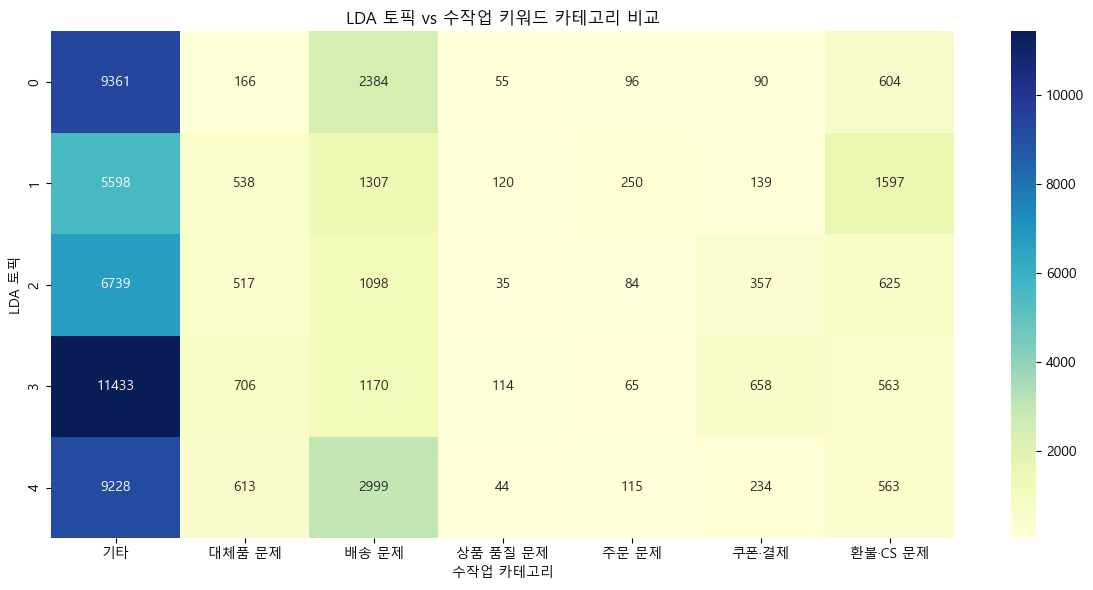

In [51]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 이후 히트맵 그리기
plt.figure(figsize=(12, 6))
sns.heatmap(comparison_table, annot=True, fmt='d', cmap="YlGnBu")
plt.title("LDA 토픽 vs 수작업 키워드 카테고리 비교")
plt.xlabel("수작업 카테고리")
plt.ylabel("LDA 토픽")
plt.tight_layout()
plt.show()


-> LDA 토픽이 지정이 수작업 키워드 카테고리보다 더 나음

In [ ]:
# LDA 토픽 대표 키워드 출력하면서 키워드 확인하기
for i, topic in lda_model.show_topics(num_topics=5, num_words=10, formatted=False):
    keywords = ", ".join([word for word, _ in topic])
    print(f"🧠 Topic {i}: {keywords}")

🧠 Topic 0: 카트, 인스타, 서비스, 이다, 고객, 그, 문제, 없다, 사용, 저
🧠 Topic 1: 주문, 더, 환불, 취소, 식료품, 배달, 내, 가격, 그, 쇼퍼
🧠 Topic 2: 그, 시간, 주문, 후, 번, 제, 도착, 운전자, 두, 경험
🧠 Topic 3: 있다, 앱, 수, 없다, 이, 사용, 가게, 그것, 그, 좋다
🧠 Topic 4: 있다, 주문, 수, 쇼핑, 이다, 없다, 쇼퍼, 서비스, 물건, 많다


- tokens_LDA할때 불용어 추가했어야함,,,, ㅎㅎㅎ
-이다, 그, 저, 있다 이런거 제거하려고 다시 custom 한거고 그걸 적용시키는거에요:)

In [53]:
custom_stopwords = [
    '정말', '진짜', '너무', '거의', '그냥', '좀', '것', '거', '에서', '으로',
    '하게', '해서', '이다', '있다', '그', '저', '이런', '그런', '그리고', '이건', '그건'
]


In [54]:
def clean_and_tokenize(text):
    tokens = okt.pos(text, stem=True)
    cleaned = [word for word, tag in tokens 
               if tag in ['Noun', 'Adjective'] and word not in custom_stopwords]
    return cleaned


In [62]:
from collections import Counter

# 모든 tokens_lda 펼쳐서 한 리스트로
all_tokens = [token for tokens in df_filtered['tokens_LDA'] for token in tokens]

# 빈도 세기
token_counts = Counter(all_tokens)

# 상위 N개 출력 (예: 50개)
print("🔎 상위 빈도 토큰 (불용어 후보):\n")
for word, count in token_counts.most_common(50):
    print(f"{word:<10} → {count}")
# 불용어 후보 50개 확인후 추가하기

🔎 상위 빈도 토큰 (불용어 후보):

있다         → 16385
주문         → 12856
없다         → 9101
수          → 8480
그          → 7997
앱          → 7319
서비스        → 6296
카트         → 6047
인스타        → 5922
이다         → 5791
이          → 5626
사용         → 5439
배달         → 4175
고객         → 4054
때          → 3810
쇼퍼         → 3683
내          → 3681
더          → 3405
문제         → 3340
제          → 3173
좋다         → 3069
시간         → 3061
배송         → 2946
환불         → 2812
말          → 2383
쇼핑         → 2350
저          → 2286
번          → 2259
추가         → 2225
다른         → 2212
위해         → 2211
물건         → 2208
같다         → 2205
후          → 2151
상품         → 2104
청구         → 2071
취소         → 2022
수수료        → 2017
항상         → 1937
때문         → 1890
많다         → 1888
지불         → 1833
돈          → 1830
동안         → 1807
나          → 1803
다시         → 1803
가게         → 1786
사람         → 1775
가격         → 1771
매우         → 1769


- 불용어 추가하고 적용하고 다시 모델 학습시키고 -> 토픽할당하고 -> 결과확인할거임...

In [101]:
from konlpy.tag import Okt

okt = Okt()

# 최신 불용어 리스트 적용
final_stopwords = [
    '정말', '진짜', '너무', '거의', '그냥', '좀', '것', '거', '에서', '으로',
    '하게', '해서', '있다', '없다', '그', '이다', '이', '때', '내', '더', '제',
    '이것', '저', '이런', '그런', '그리고', '이건', '그건', '정도', '같다'
    ,'정말', '진짜', '너무', '거의', '그냥', '좀', '것', '거', '에서', '으로',
    '하게', '해서', '이다', '있다', '그', '저', '이런', '그런', '그리고',
    '이건', '그건', '이', '수', '없다', '후', '전', '사용자'
]

# 전처리 함수
def clean_and_tokenize(text):
    tokens = okt.pos(text, stem=True)
    return [
        word for word, tag in tokens
        if tag in ['Noun', 'Adjective'] and word not in final_stopwords
    ]

# tokens_lda 컬럼 재생성
df_filtered['tokens_lda'] = df_filtered['리뷰'].apply(clean_and_tokenize)


In [102]:
# LDA 모델 재학습하는 거랑 딕셔너리,corpus 생성하는거
from gensim import corpora, models

# 텍스트 리스트
texts = df_filtered['tokens_lda'].tolist()

# 사전 생성 및 정제
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=2, no_above=0.95)

# 문서-단어 행렬 (BoW)
corpus = [dictionary.doc2bow(text) for text in texts]

# LDA 모델 학습
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=10
)

In [103]:
# 가장 높은 확률의 토픽을 문서에 할당
def get_topic_id(doc_bow):
    topics = lda_model.get_document_topics(doc_bow)
    return sorted(topics, key=lambda x: -x[1])[0][0] if topics else -1

df_filtered['topic_cluster'] = [get_topic_id(doc) for doc in corpus]


In [104]:
for i, topic in lda_model.show_topics(num_topics=5, num_words=10, formatted=False):
    keywords = ", ".join([word for word, _ in topic])
    print(f"🧠 Topic {i}: {keywords}")


🧠 Topic 0: 주문, 앱, 고객, 사용, 서비스, 다시, 채팅, 취소, 이메일, 도움
🧠 Topic 1: 앱, 좋다, 사용, 쇼퍼, 서비스, 시간, 가게, 쇼핑, 카트, 식료품
🧠 Topic 2: 그것, 나, 멤버십, 위해, 생각, 카드, 많다, 멀리, 회원, 찾기
🧠 Topic 3: 주문, 상품, 가격, 개, 쇼퍼, 취소, 재고, 시간, 제품, 인스타
🧠 Topic 4: 주문, 서비스, 고객, 환불, 인스타, 카트, 청구, 배달, 취소, 연락


In [105]:
# 1. 토픽 번호에 따른 해석된 라벨 정의
topic_label_map = {
    0: "환불 처리 지연 및 고객 응대 문제",
    1: "원치 않는 대체상품 문제",
    2: "상품 파손 및 신선도 불만",
    3: "쇼퍼의 태도 및 커뮤니케이션 문제",
    4: "앱/서비스 오류 및 사용성 문제"
}

# 2. 매핑하여 새로운 컬럼 추가
df_filtered['topic_label'] = df_filtered['topic_cluster'].map(topic_label_map)

-> 주문문제, 배송문제, 대체품 문제, 환불Cs 문제, 상품 품질 문제, 쿠폰결제를 처음에 피드백 해주신거를 바탕으로 분류한건데 토픽 번호에 따른 라벨 정의를 이렇게 해도 되나? 순간 고민이 됐었는데 이건 LDA는 자동 클러스터링이고 주요 키워드를 보고 라벨을 정의한거라 괜찮을 것 같다는 판단을 헀어요 

In [106]:
# 중복 문장 제거용 집합
seen_sentences = set()

# 토픽별 문장 출력
for topic_id in sorted(df_filtered['topic_cluster'].unique()):
    # 해당 토픽의 라벨 가져오기
    topic_name = df_filtered[df_filtered['topic_cluster'] == topic_id]['topic_label'].iloc[0]

    print(f"\n📌 [Topic {topic_id}] {topic_name} ")

    # 중복 제거된 문장만 추출
    topic_sentences = df_filtered[df_filtered['topic_cluster'] == topic_id]['sentences'].drop_duplicates()

    count = 0
    for sent in topic_sentences:
        if sent not in seen_sentences:
            print("-", sent)
            seen_sentences.add(sent)
            count += 1
        if count >= 3:
            break


📌 [Topic 0] 환불 처리 지연 및 고객 응대 문제 
- 만약 할 수 있다면 0점을 줄 것입니다
- 안타깝게도 그런 옵션이 없지만, 필요하다면 매일 이 작업을 할 것입니다
- 처음에 멤버십으로 나를 속여서 비용을 뜯어내었음에도 불구하고 1년 동안 이 앱을 사용해 왔습니다

📌 [Topic 1] 원치 않는 대체상품 문제 
- 다른 주소로 전혀 내 집이 아닌 곳으로 배달된 식료품에 200달러를 썼고, 쇼퍼와 대화를 시도했고, 실제 주소/집으로 주문을 가져다 줄 수 있다면 가스비와 이동비를 보상해주겠다고 제안했지만, 쇼퍼는 배달되었다고 하고 주문을 거기에 두고 떠났다
- 나는 모든 리뷰와 항소 과정을 거쳤지만 아무것도 받지 못했다
- 200달러를 낭비했고, 나는 수년간 충실한 고객이었다

📌 [Topic 2] 상품 파손 및 신선도 불만 
- 형편없는 고객 서비스 도움
솔직히 말해서, 저는 인스타카트가 시작된 이후로 계속 일하고 수익을 올리는 데 큰 도움이 되었습니다
- 그러나 지원이 필요한 경우에는 하늘이 당신을 도와주길 바랍니다
- 긴 대기 시간, 끊긴 전화, 전화나 이메일로의 회신 없음

📌 [Topic 3] 쇼퍼의 태도 및 커뮤니케이션 문제 
- 인스타카트 캐나다에 대한 리뷰입니다
- 주문을 했는데 크레딧이 적용되지 않았습니다
- 적용되도록 전화했지만, 대화 중에 강한 자메이칸 사투리를 하는 대리인이 다른 사람과 이야기를 시작하고 나를 무시했습니다

📌 [Topic 4] 앱/서비스 오류 및 사용성 문제 
- 내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다
- 어떤 이유로 인해 앱의 매핑이 운전자를 완전히 다른 도시로 보냈습니다
- 운전자에게 메시지를 보내서 GPS를 사용하여 건물을 찾도록 요청했습니다 (실제 시청 건물)


In [107]:
df_filtered['topic_cluster'].value_counts().sort_index()

topic_cluster
0     9719
1    19656
2     4867
3     6325
4    19698
Name: count, dtype: int64

In [108]:

df_filtered.groupby('topic_cluster')['rating'].mean()

topic_cluster
0    1.439037
1    3.236416
2    1.447709
3    1.935178
4    1.563509
Name: rating, dtype: float64

C:\Users\User\AppData\Local\Temp\ipykernel_17464\83927444.py:42: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


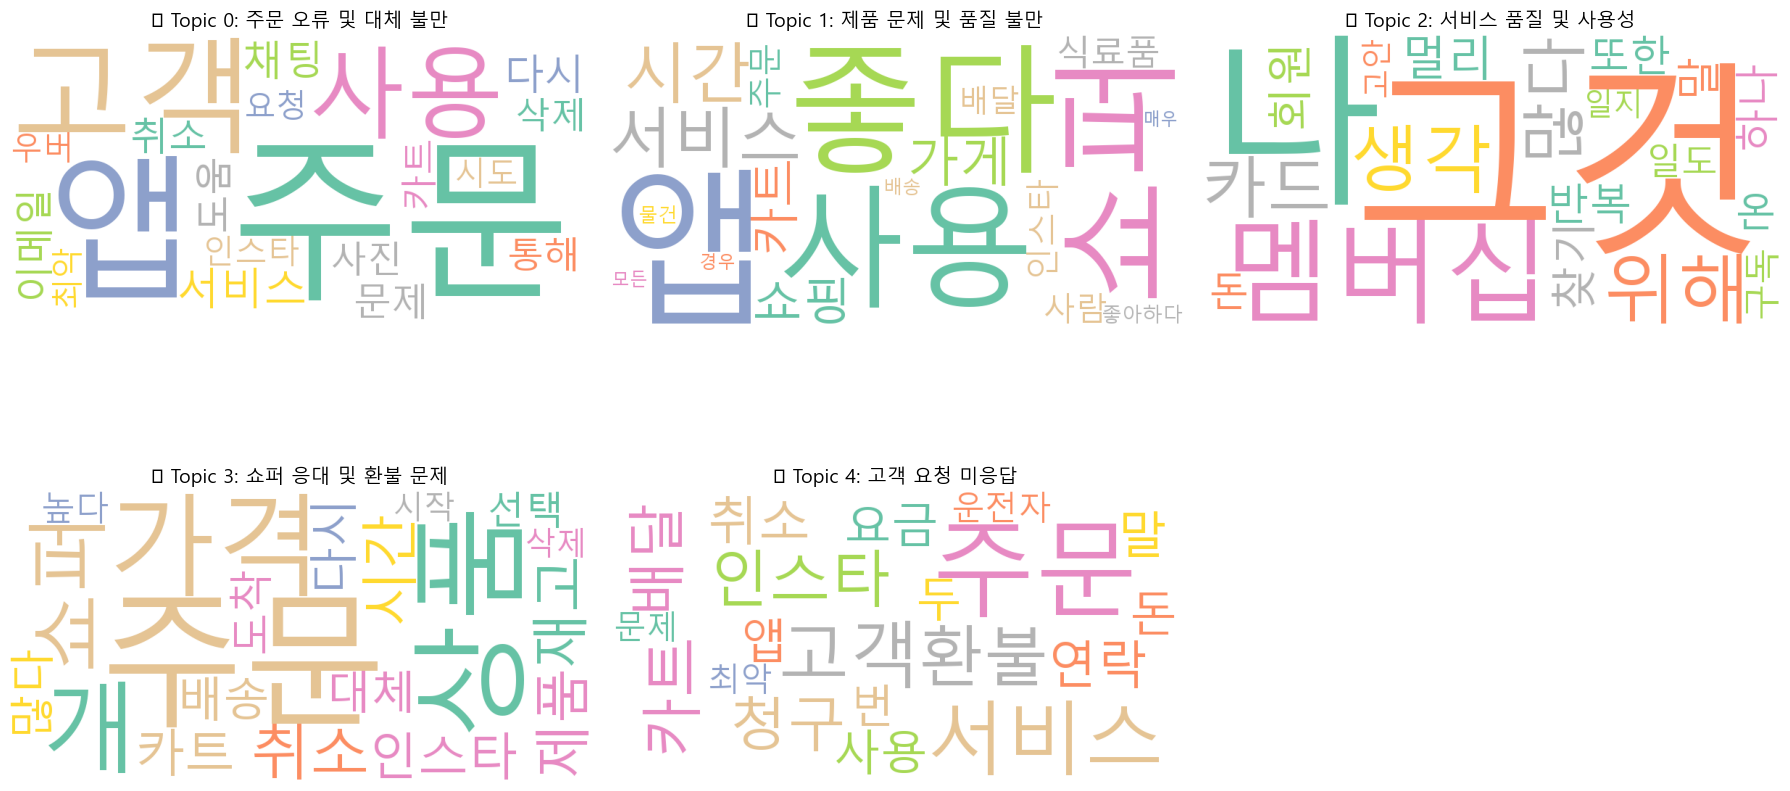

In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# 주제 매핑
topic_label_map = {
    0: "환불 처리 지연 및 고객 응대 문제",
    1: "원치 않는 대체상품 문제",
    2: "상품 파손 및 신선도 불만",
    3: "쇼퍼의 태도 및 커뮤니케이션 문제",
    4: "앱/서비스 오류 및 사용성 문제"
}

# 시각화 레이아웃
n_topics = len(topic_labels)
ncols = 3
nrows = (n_topics + ncols - 1) // ncols

plt.figure(figsize=(18, 10))

# 🔥 반드시 lda_model에서 show_topics 호출
for i, (topic_id, topic) in enumerate(lda_model.show_topics(formatted=False, num_words=20)):
    words = dict(topic)
    wc = WordCloud(
        font_path=font_path,
        background_color="white",
        colormap='Set2',
        width=800,
        height=400
    )

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(wc.generate_from_frequencies(words))
    plt.axis('off')
    title_text = f"🧩 Topic {topic_id}: {topic_labels.get(topic_id, 'Unknown')}"
    plt.title(title_text, fontproperties=font_prop, fontsize=14)

plt.tight_layout()
plt.show()


In [110]:

for row in summary_data:
    print(f"\n🧠 {row['토픽 번호']} - {row['불만 유형']}")
    print(f"📌 주요 키워드: {row['대표 키워드']}")
    print("📝 대표 문장:\n" + row['대표 문장'])


🧠 Topic 0 - 환불 처리 지연 및 고객 응대 문제
📌 주요 키워드: 수, 앱, 서비스, 주문, 사용, 시간, 좋다, 가게, 가격, 많다
📝 대표 문장:
1. 만약 할 수 있다면 0점을 줄 것입니다
2. 안타깝게도 그런 옵션이 없지만, 필요하다면 매일 이 작업을 할 것입니다
3. 처음에 멤버십으로 나를 속여서 비용을 뜯어내었음에도 불구하고 1년 동안 이 앱을 사용해 왔습니다

🧠 Topic 1 - 원치 않는 대체상품 문제
📌 주요 키워드: 주문, 상품, 서비스, 환불, 쇼퍼, 배달, 제품, 개, 청구, 다른
📝 대표 문장:
1. 내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다
2. 어떤 이유로 인해 앱의 매핑이 운전자를 완전히 다른 도시로 보냈습니다
3. 운전자에게 메시지를 보내서 GPS를 사용하여 건물을 찾도록 요청했습니다 (실제 시청 건물)

🧠 Topic 2 - 상품 파손 및 신선도 불만
📌 주요 키워드: 카트, 수, 인스타, 앱, 사람, 생각, 인간, 문제, 배달, 잘못
📝 대표 문장:
1. 다른 주소로 전혀 내 집이 아닌 곳으로 배달된 식료품에 200달러를 썼고, 쇼퍼와 대화를 시도했고, 실제 주소/집으로 주문을 가져다 줄 수 있다면 가스비와 이동비를 보상해주겠다고 제안했지만, 쇼퍼는 배달되었다고 하고 주문을 거기에 두고 떠났다
2. 나는 모든 리뷰와 항소 과정을 거쳤지만 아무것도 받지 못했다
3. 200달러를 낭비했고, 나는 수년간 충실한 고객이었다

🧠 Topic 3 - 쇼퍼의 태도 및 커뮤니케이션 문제
📌 주요 키워드: 주문, 취소, 후, 고객, 다시, 서비스, 전화, 카트, 시간, 인스타
📝 대표 문장:
1. 10번 중 8번은 최악의 경험이었습니다
2. 마지막으로 쇼퍼가 아이스크림 3상자를 쿨한 온도에 넣지 않아서 $120짜리 쇼핑이 완전히 녹아버린 아이스크림으로 망가졌습니다
3. $18 환불을 요청했지만 무시당했습니다

🧠 Topic 4 - 앱/서비스 오류 및 사용성 문제
📌 주요 키워드: 고객, 서비스, 나,

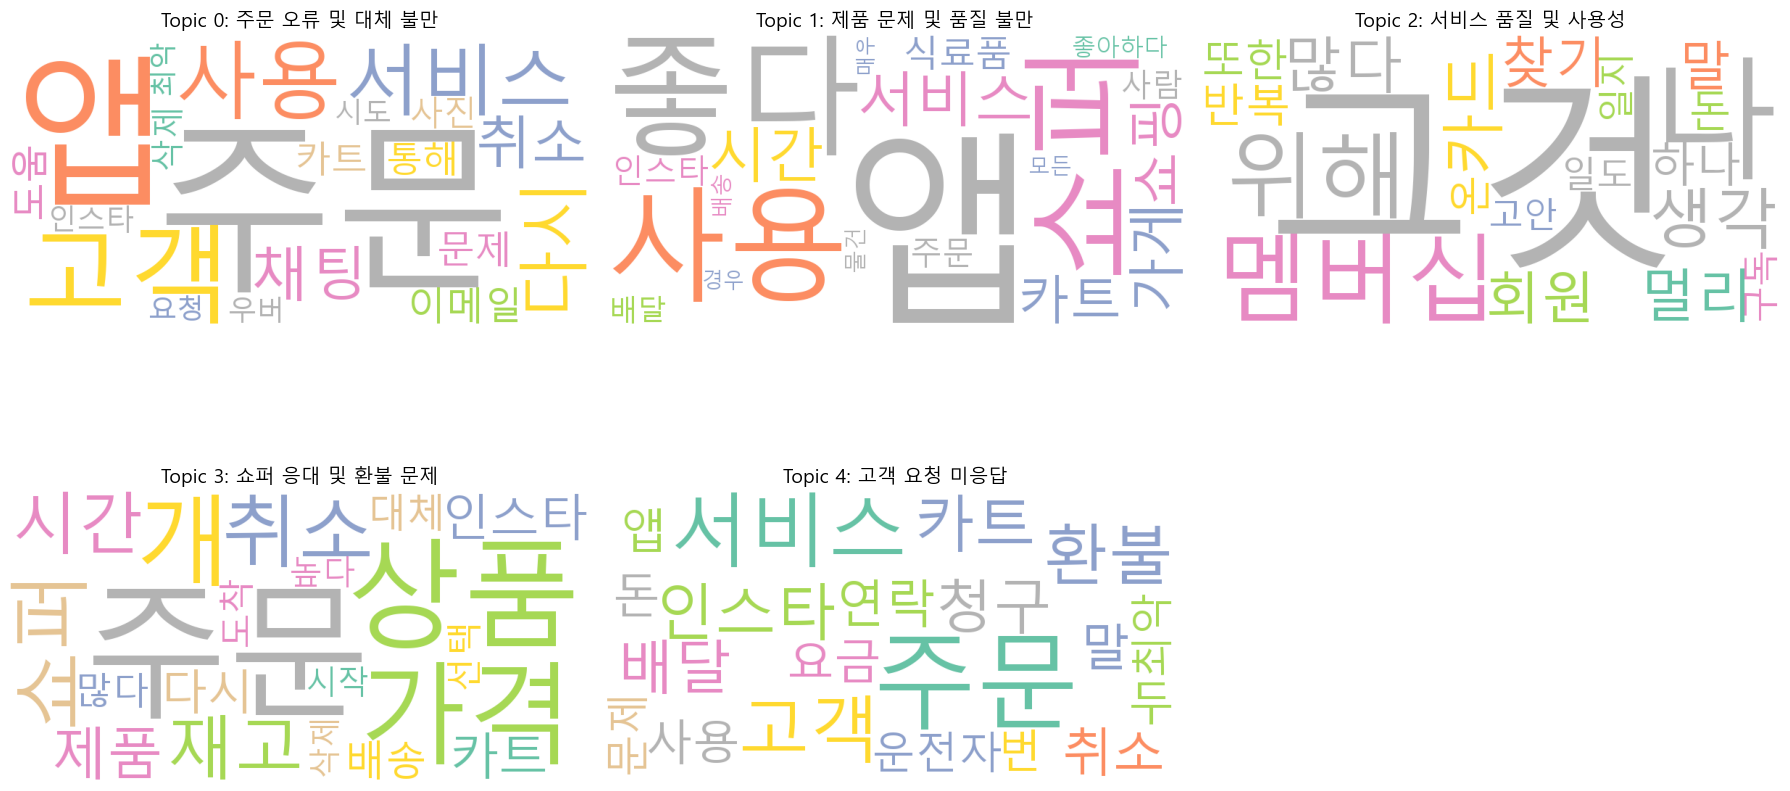

In [111]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# 주제명 매핑
topic_labels = {
    0: "주문 오류 및 대체 불만",
    1: "제품 문제 및 품질 불만",
    2: "서비스 품질 및 사용성",
    3: "쇼퍼 응대 및 환불 문제",
    4: "고객 요청 미응답"
}

# 시각화 설정
n_topics = len(topic_labels)
ncols = 3
nrows = (n_topics + ncols - 1) // ncols

plt.figure(figsize=(18, 10))

for i, (topic_id, topic) in enumerate(lda_model.show_topics(formatted=False, num_words=20)):
    words = dict(topic)
    wc = WordCloud(font_path=font_path, background_color="white", width=800, height=400)

   
    wc = WordCloud(
        font_path=font_path,
        background_color="white",
        colormap= 'Set2',
        width=800,
        height=400
    )

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(wc.generate_from_frequencies(words))
    plt.axis('off')
    title_text = f"Topic {topic_id}: {topic_labels.get(topic_id, 'Unknown')}"
    plt.title(title_text, fontproperties=font_prop, fontsize=14)

plt.tight_layout()
plt.show()

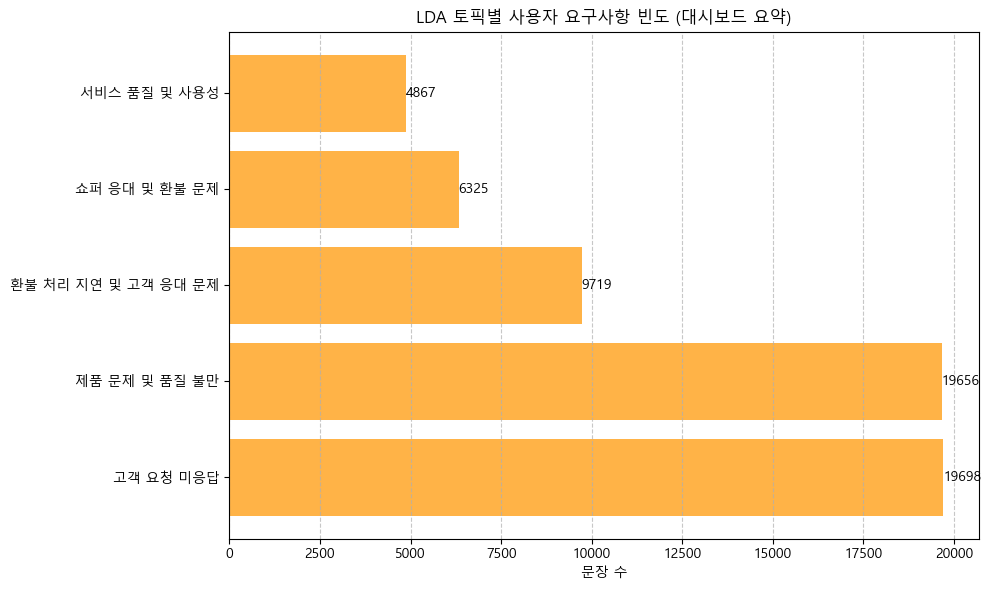

In [112]:
import matplotlib.pyplot as plt

# 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'

# LDA 토픽 라벨 정의 (lda_model 기반으로 분류된 토픽 번호와 매핑)
lda_topic_labels = {
    0: "환불 처리 지연 및 고객 응대 문제",
    1: "제품 문제 및 품질 불만",
    2: "서비스 품질 및 사용성",
    3: "쇼퍼 응대 및 환불 문제",
    4: "고객 요청 미응답"
}

# LDA 기반 문장 수 요약 테이블
lda_summary = df_filtered['topic_cluster'].map(lda_topic_labels).value_counts().reset_index()
lda_summary.columns = ['토픽 주제', '문장 수']
lda_summary = lda_summary.sort_values('문장 수')  # y축 뒤집기용

# 수평 막대그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.barh(lda_summary['토픽 주제'], lda_summary['문장 수'], color="#FFB347")
plt.xlabel("문장 수")
plt.title("LDA 토픽별 사용자 요구사항 빈도 (대시보드 요약)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 바 라벨 추가
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
             f"{int(bar.get_width())}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [113]:
# LDA 토픽별 주요 키워드 추출
top_keywords_per_topic = []

for topic_id, topic in lda_model.show_topics(num_topics=5, num_words=10, formatted=False):
    keywords = [word for word, _ in topic]
    top_keywords_per_topic.append({
        "토픽": topic_id,
        "대표 키워드": ", ".join(keywords)
    })

# DataFrame으로 변환
df_top_keywords_lda = pd.DataFrame(top_keywords_per_topic)
df_top_keywords_lda

,토픽,대표 키워드
0,0,"주문, 앱, 고객, 사용, 서비스, 다시, 채팅, 취소, 이메일, 도움"
1,1,"앱, 좋다, 사용, 쇼퍼, 서비스, 시간, 가게, 쇼핑, 카트, 식료품"
2,2,"그것, 나, 멤버십, 위해, 생각, 카드, 많다, 멀리, 회원, 찾기"
3,3,"주문, 상품, 가격, 개, 쇼퍼, 취소, 재고, 시간, 제품, 인스타"
4,4,"주문, 서비스, 고객, 환불, 인스타, 카트, 청구, 배달, 취소, 연락"


In [115]:
clusters = df_top_keywords_lda['토픽'].unique()
clusters

array([0, 1, 2, 3, 4], dtype=int64)

In [116]:
print(df_top_keywords_lda.columns)

Index(['토픽', '대표 키워드'], dtype='object')


In [117]:
# gensim LDA 모델로부터 토픽 키워드 가져오기
top_keywords = []
for topic_id in range(lda_model.num_topics):
    for word, prob in lda_model.show_topic(topic_id, topn=10):
        top_keywords.append({'토픽': topic_id, '키워드': word, '등장 확률': round(prob * 100, 2)})

df_keywords_bar = pd.DataFrame(top_keywords)


In [118]:
top_keywords = []
for topic_id in range(lda_model.num_topics):
    for word, prob in lda_model.show_topic(topic_id, topn=10):
        top_keywords.append({
            '토픽': topic_id,
            '키워드': word,
            '등장 확률': round(prob * 100, 2)
        })

df_keywords_bar = pd.DataFrame(top_keywords)

- LDA 토픽마다 어떤 키워드가 얼마나 자주 등장했는지 궁금해서 막대그래프로 나타내기 위해 위에 코드로 만든거고 
- 토픽 4개중 상위 10개 키워드를 뽑고 단순히 카운트하는것보다 확률로 나타내면 토픽의 의미를 알 수 있지 않을까해서 확률로 나타냈는데
- 사용자입장에서 실제로 많이썼는지 확인하기 위해서 빈도로도 확인해야겠다,,,

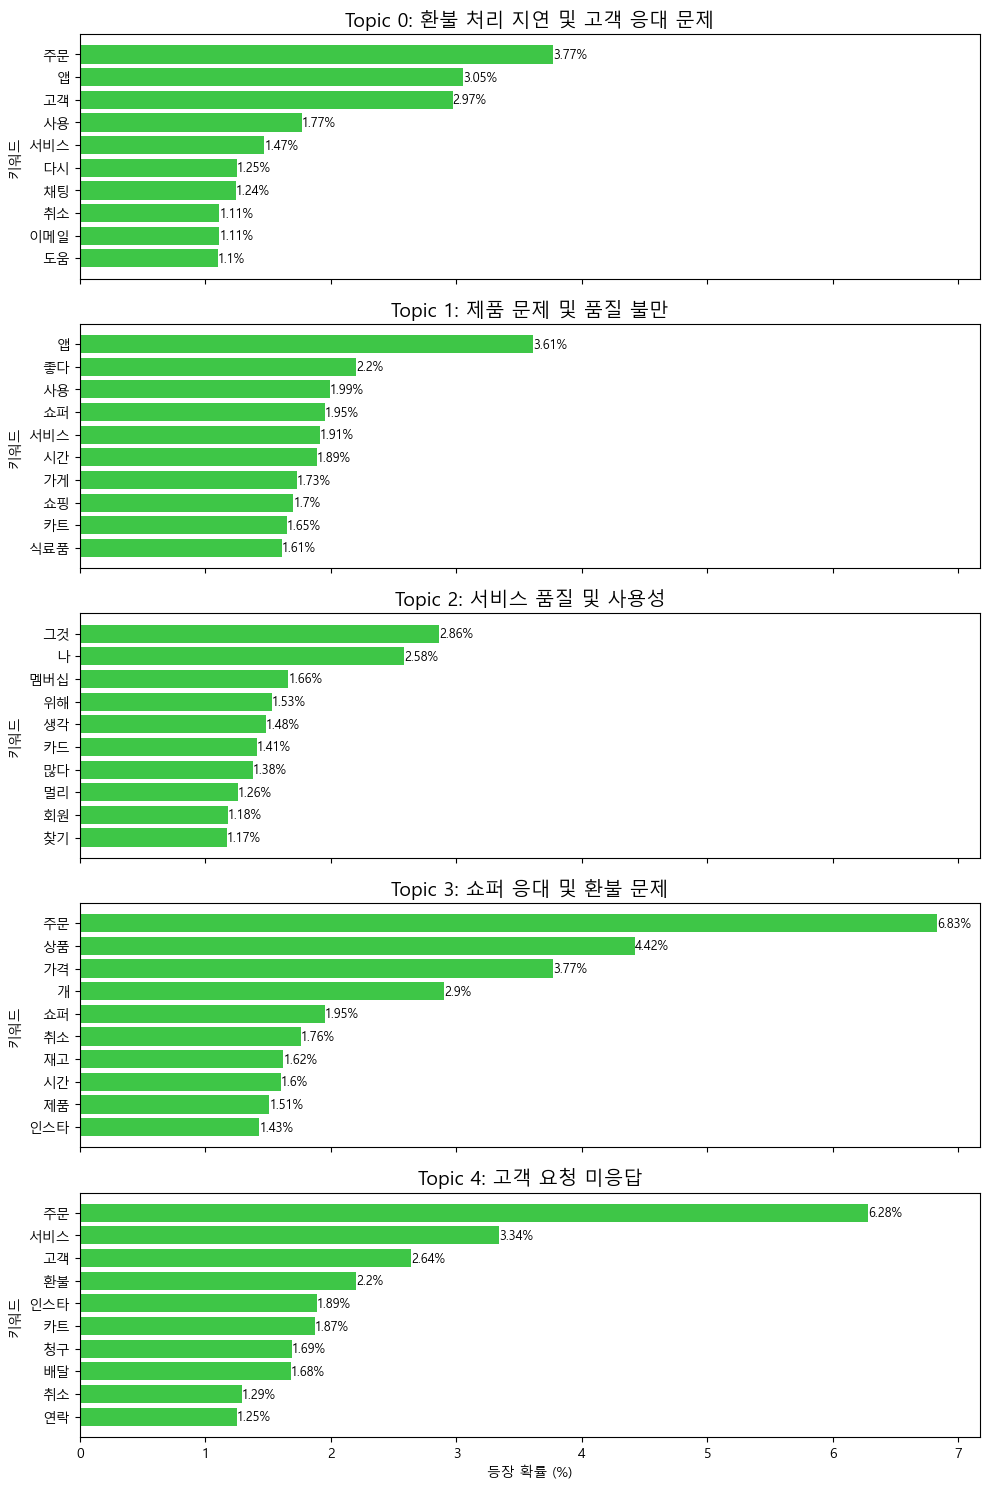

In [132]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

lda_topic_labels = {
    0: "환불 처리 지연 및 고객 응대 문제",
    1: "제품 문제 및 품질 불만",
    2: "서비스 품질 및 사용성",
    3: "쇼퍼 응대 및 환불 문제",
    4: "고객 요청 미응답"
}
clusters = df_keywords_bar['토픽'].unique()
num_clusters = len(clusters)

fig, axes = plt.subplots(num_clusters, 1, figsize=(10, 3 * num_clusters), sharex=True)

if num_clusters == 1:
    axes = [axes]

for i, topic_id in enumerate(clusters):
    data = df_keywords_bar[df_keywords_bar['토픽'] == topic_id]
    bars = axes[i].barh(data['키워드'], data['등장 확률'], color="#3EC647")

    title = f"Topic {topic_id}: {lda_topic_labels.get(topic_id, f'Topic {topic_id}')}"
    axes[i].set_title(title, fontproperties=font_prop, fontsize=14)
    axes[i].set_ylabel("키워드", fontproperties=font_prop)
    axes[i].invert_yaxis()

    for bar in bars:
        width = bar.get_width()
        axes[i].text(width, bar.get_y() + bar.get_height() / 2,
                     f"{width}%", va='center', fontsize=9)

axes[-1].set_xlabel("등장 확률 (%)", fontproperties=font_prop)
plt.tight_layout()
plt.show()


- 그것, 나 , 개, 이것도 빼야할 것 같아요

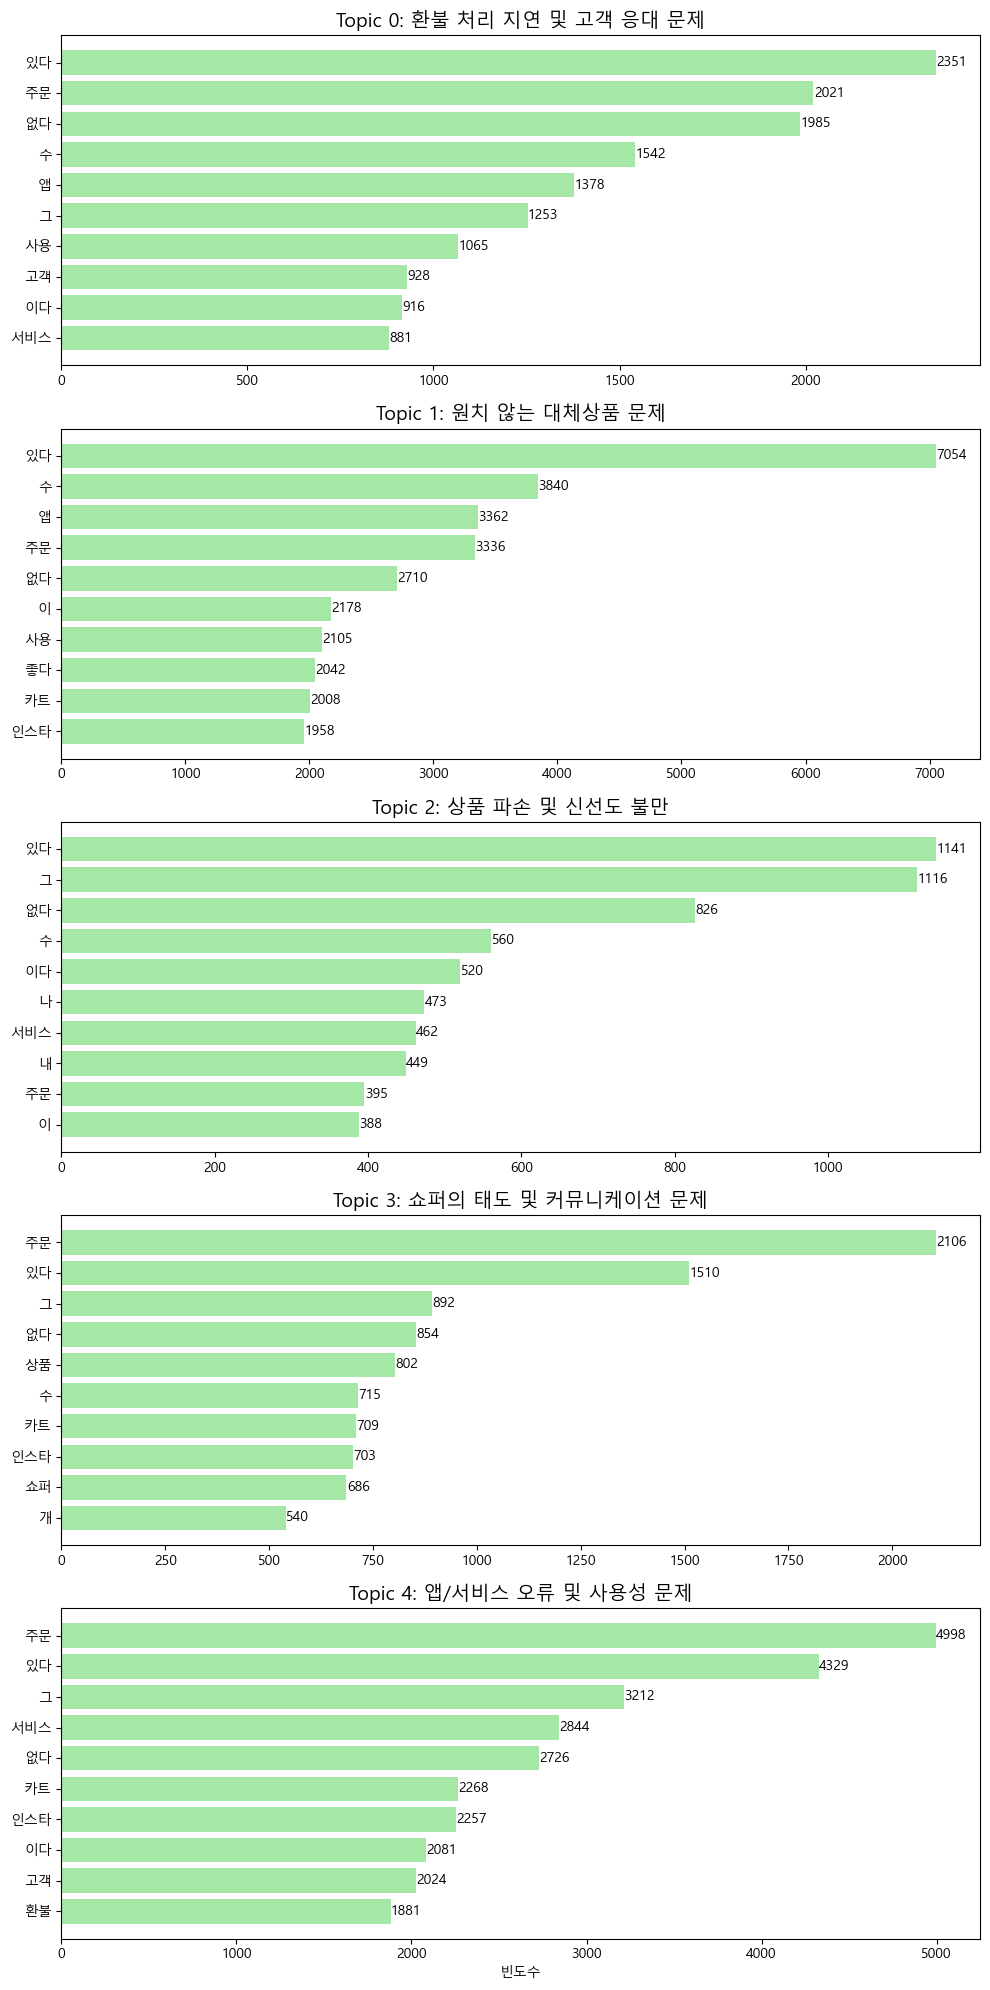

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from collections import Counter

# 폰트 설정 (윈도우 기준)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# LDA 토픽 라벨 
lda_topic_labels = {
    0: "환불 처리 지연 및 고객 응대 문제",
    1: "제품 문제 및 품질 불만",
    2: "서비스 품질 및 사용성",
    3: "쇼퍼 응대 및 환불 문제",
    4: "고객 요청 미응답"
}
# 토픽 수
topics = sorted(df_filtered['topic_cluster'].unique())
n_topics = len(topics)

# 시각화 설정
fig, axes = plt.subplots(n_topics, 1, figsize=(10, 4 * n_topics), sharex=False)

# subplot이 1개일 경우 처리
if n_topics == 1:
    axes = [axes]

# 각 토픽별로 키워드 빈도 계산 및 시각화
for i, topic in enumerate(topics):
    tokens_in_topic = df_filtered[df_filtered['topic_cluster'] == topic]['tokens_LDA']
    flat_tokens = [token for tokens in tokens_in_topic for token in tokens]
    counter = Counter(flat_tokens)
    top_keywords = counter.most_common(10)

    keywords, freqs = zip(*top_keywords)

    axes[i].barh(keywords, freqs, color="#A5E7A7")
    axes[i].set_title(f"Topic {topic}: {topic_label_map.get(topic)}", fontproperties=font_prop, fontsize=14)
    axes[i].invert_yaxis()  # 높은 빈도가 위로 오게

    for j, freq in enumerate(freqs):
        axes[i].text(freq + 1, j, str(freq), va='center', fontsize=10)

axes[-1].set_xlabel("빈도수", fontproperties=font_prop)
plt.tight_layout()
plt.show()


있다, 없다, 수 , 이, 이다, 그 , 후, <- 이게 불용어처리가 잘안된거같네,,, 다시 ,,,
하고 왔는데 이 빈도수는 업데이트가 왜 안된거 같죠,,,

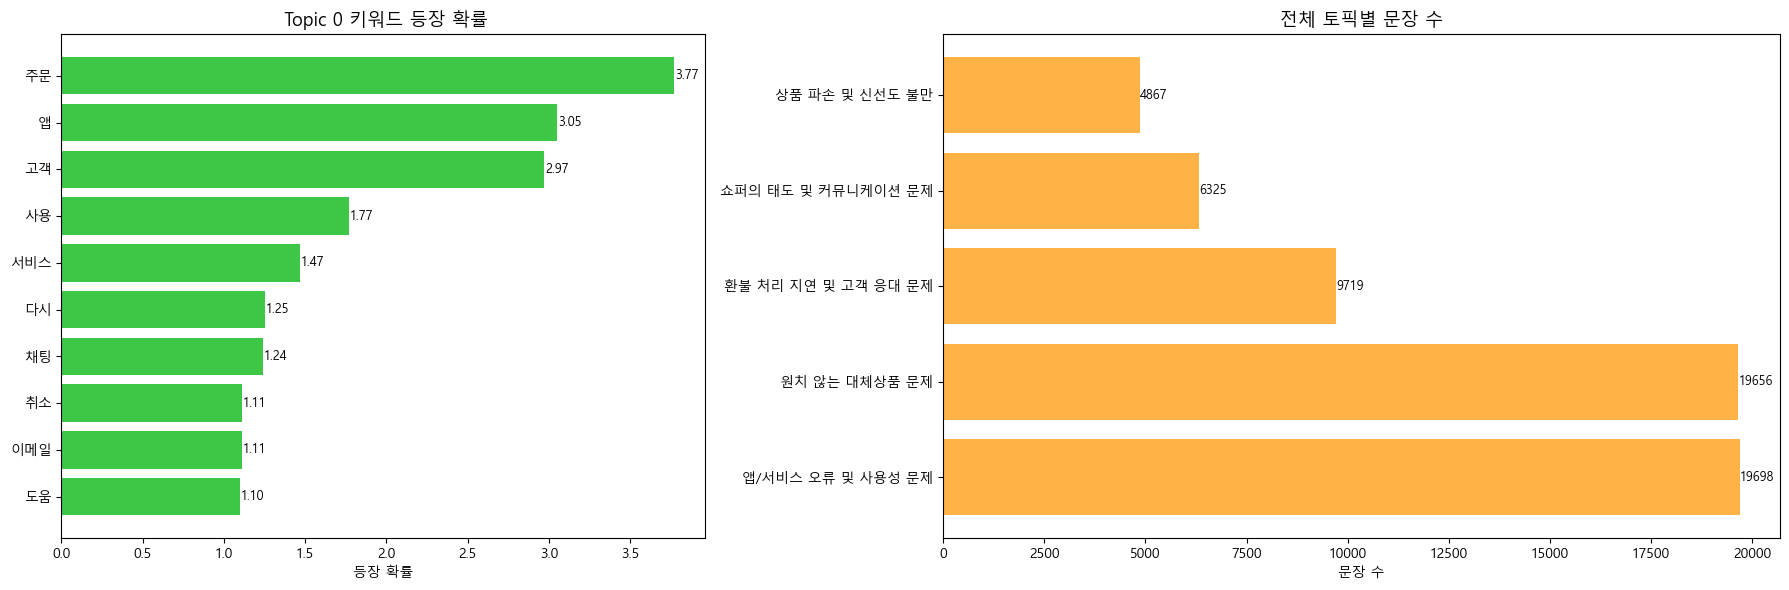

In [134]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
plt.rcParams['font.family'] = 'Malgun Gothic'

# 사용할 토픽 번호 지정
topic_id = 0

# 토픽 라벨 매핑
lda_topic_labels = {
    0: "환불 처리 지연 및 고객 응대 문제",
    1: "제품 문제 및 품질 불만",
    2: "서비스 품질 및 사용성",
    3: "쇼퍼 응대 및 환불 문제",
    4: "고객 요청 미응답"
}

# 시각화 시작
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), width_ratios=[1, 1.3])

# 왼쪽: 특정 토픽의 키워드 등장 확률
keywords_data = df_keywords_bar[df_keywords_bar['토픽'] == topic_id]
bars1 = ax1.barh(keywords_data['키워드'], keywords_data['등장 확률'], color="#3EC647")
ax1.set_title(f" Topic {topic_id} 키워드 등장 확률", fontsize=13)
ax1.invert_yaxis()
ax1.set_xlabel("등장 확률")

# 수치 표시
for bar in bars1:
    width = bar.get_width()
    ax1.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}", va='center', fontsize=9)

# 오른쪽: 전체 토픽별 문장 수
topic_counts = df_filtered['topic_cluster'].map(topic_label_map).value_counts().sort_values()
bars2 = ax2.barh(topic_counts.index, topic_counts.values, color="#FFB347")
ax2.set_title("전체 토픽별 문장 수", fontsize=13)
ax2.set_xlabel("문장 수")
ax2.invert_yaxis()

# 수치 표시
for bar in bars2:
    count = int(bar.get_width())
    ax2.text(count + 1, bar.get_y() + bar.get_height() / 2,
             f"{count}", va='center', fontsize=9)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, ' 각 토픽별 문장 수')

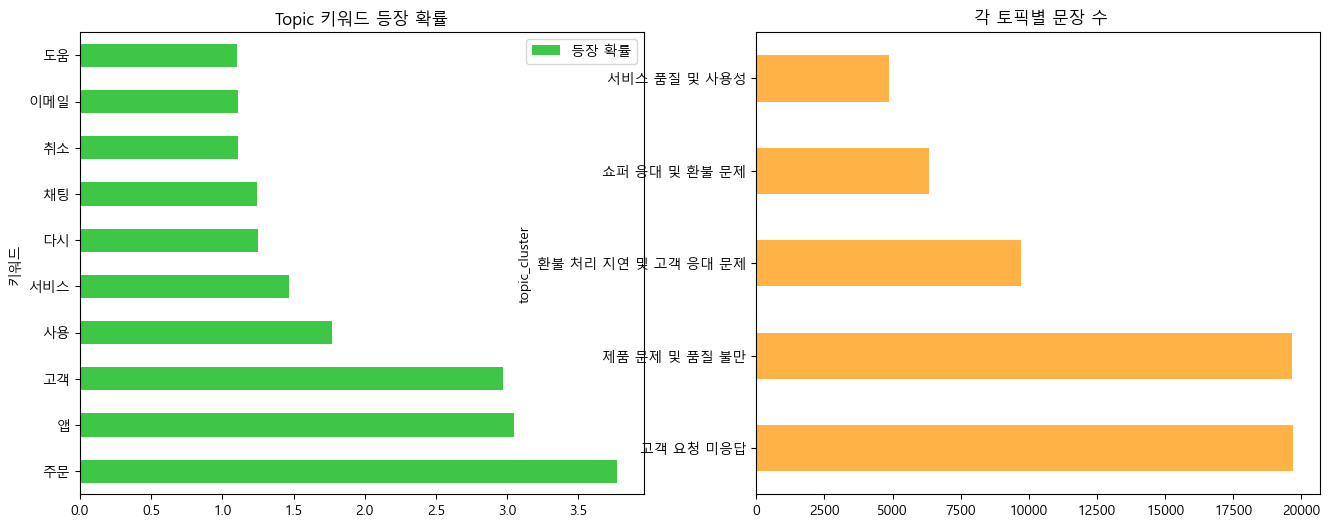

In [135]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 왼쪽: 키워드 등장 확률
df_keywords_bar[df_keywords_bar['토픽'] == 0].plot.barh(x='키워드', y='등장 확률', ax=ax1, color="#3EC647")
ax1.set_title("Topic 키워드 등장 확률")

# 오른쪽: 문장 수 카운트
df_filtered['topic_cluster'].map(lda_topic_labels).value_counts().plot.barh(ax=ax2, color="#FFB347")
ax2.set_title(" 각 토픽별 문장 수") 

-> 원래 이게 기존이였는데 이름이 길어서 넘어와서 바로 위에 코드로 바꿔봤어요

-------------tokens_cluster 활용------------------------------------

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 토큰을 공백 기준 문자열로 다시 합침
df_filtered['cluster_doc'] = df_filtered['tokens_cluster'].apply(lambda x: ' '.join(x))

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_filtered['cluster_doc'])

# KMeans 클러스터링
kmeans = KMeans(n_clusters=5, random_state=42)
df_filtered['cluster'] = kmeans.fit_predict(X)


In [139]:
# 1. TF-IDF 벡터화
df_filtered['cluster_doc'] = df_filtered['tokens_cluster'].apply(lambda x: ' '.join(x))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(max_features=1000)
X_cluster = vectorizer.fit_transform(df_filtered['cluster_doc'])

# 2. 클러스터링
kmeans = KMeans(n_clusters=5, random_state=42)
df_filtered['cluster'] = kmeans.fit_predict(X_cluster)


In [141]:
import numpy as np

terms = vectorizer.get_feature_names_out()

# 클러스터 4 주요 키워드
mean_tfidf_c4 = X_cluster[df_filtered['cluster'] == 4].mean(axis=0).A1
top_idx_c4 = np.argsort(mean_tfidf_c4)[::-1][:10]
cluster4_keywords = [terms[j] for j in top_idx_c4]

# 토픽 4 주요 키워드
from collections import Counter

tokens_topic4 = df_filtered[df_filtered['topic_cluster'] == 4]['tokens_LDA']
flat_tokens = [token for tokens in tokens_topic4 for token in tokens]
top_topic4_keywords = [word for word, _ in Counter(flat_tokens).most_common(10)]

# 대표 문장 추출
topic4_sentences = df_filtered[df_filtered['topic_cluster'] == 4]['sentences'].drop_duplicates().head(3).tolist()
cluster4_sentences = df_filtered[df_filtered['cluster'] == 4]['sentences'].drop_duplicates().head(3).tolist()

# 비교 출력
print("💡 LDA Topic 4 (앱/서비스 오류 및 사용성 문제)")
print("<주요 키워드:>", top_topic4_keywords)
print("대표 문장:")
for s in topic4_sentences:
    print("-", s)

print("\n💡 TF-IDF Cluster 4")
print("< 주요 키워드:>", cluster4_keywords)
print(" 대표 문장:")
for s in cluster4_sentences:
    print("-", s)


💡 LDA Topic 4 (앱/서비스 오류 및 사용성 문제)
<주요 키워드:> ['주문', '있다', '그', '서비스', '없다', '카트', '인스타', '이다', '고객', '환불']
대표 문장:
- 내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다
- 어떤 이유로 인해 앱의 매핑이 운전자를 완전히 다른 도시로 보냈습니다
- 운전자에게 메시지를 보내서 GPS를 사용하여 건물을 찾도록 요청했습니다 (실제 시청 건물)

💡 TF-IDF Cluster 4
< 주요 키워드:> ['주문', '시간', '배송', '취소', '쇼퍼', '배달', '물건', '지불', '서비스', '도착']
 대표 문장:
- 다른 주소로 전혀 내 집이 아닌 곳으로 배달된 식료품에 200달러를 썼고, 쇼퍼와 대화를 시도했고, 실제 주소/집으로 주문을 가져다 줄 수 있다면 가스비와 이동비를 보상해주겠다고 제안했지만, 쇼퍼는 배달되었다고 하고 주문을 거기에 두고 떠났다
- 나는 모든 리뷰와 항소 과정을 거쳤지만 아무것도 받지 못했다
- 200달러를 낭비했고, 나는 수년간 충실한 고객이었다


-> 이렇게 비교해서 보니까 LDA보다 TF-IDF가 더 키워드별로는 잘되긴했는데
- 당연함 LDA는 형용사를 집어넣었고 Cluster사용할건 명사만 넣었으니까,,ㅎ

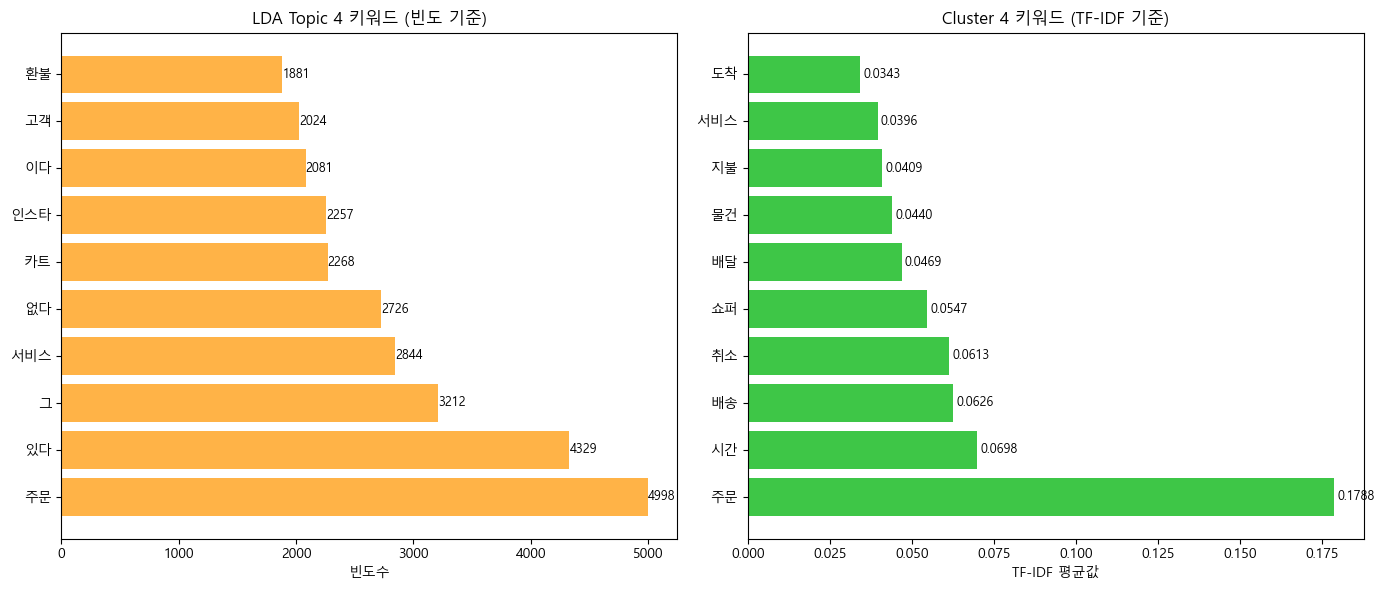

In [143]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 키워드 데이터
lda_keywords = Counter(flat_tokens).most_common(10)
lda_words, lda_freqs = zip(*lda_keywords)

cluster_freqs = mean_tfidf_c4[top_idx_c4]
cluster_words = cluster4_keywords

# 그래프 그리기
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# === LDA 막대그래프 ===
bars_lda = axes[0].barh(lda_words[::-1], lda_freqs[::-1], color="#FFB347")
axes[0].set_title("LDA Topic 4 키워드 (빈도 기준)")
axes[0].set_xlabel("빈도수")
axes[0].invert_yaxis()

# LDA 수치 표시
for bar in bars_lda:
    width = bar.get_width()
    axes[0].text(width + 1, bar.get_y() + bar.get_height() / 2,
                 f"{int(width)}", va='center', fontsize=9)

# === Cluster 막대그래프 ===
bars_cluster = axes[1].barh(cluster_words[::-1], cluster_freqs[::-1], color="#3EC647")
axes[1].set_title("Cluster 4 키워드 (TF-IDF 기준)")
axes[1].set_xlabel("TF-IDF 평균값")
axes[1].invert_yaxis()

# Cluster 수치 표시
for bar in bars_cluster:
    width = bar.get_width()
    axes[1].text(width + 0.001, bar.get_y() + bar.get_height() / 2,
                 f"{width:.4f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()


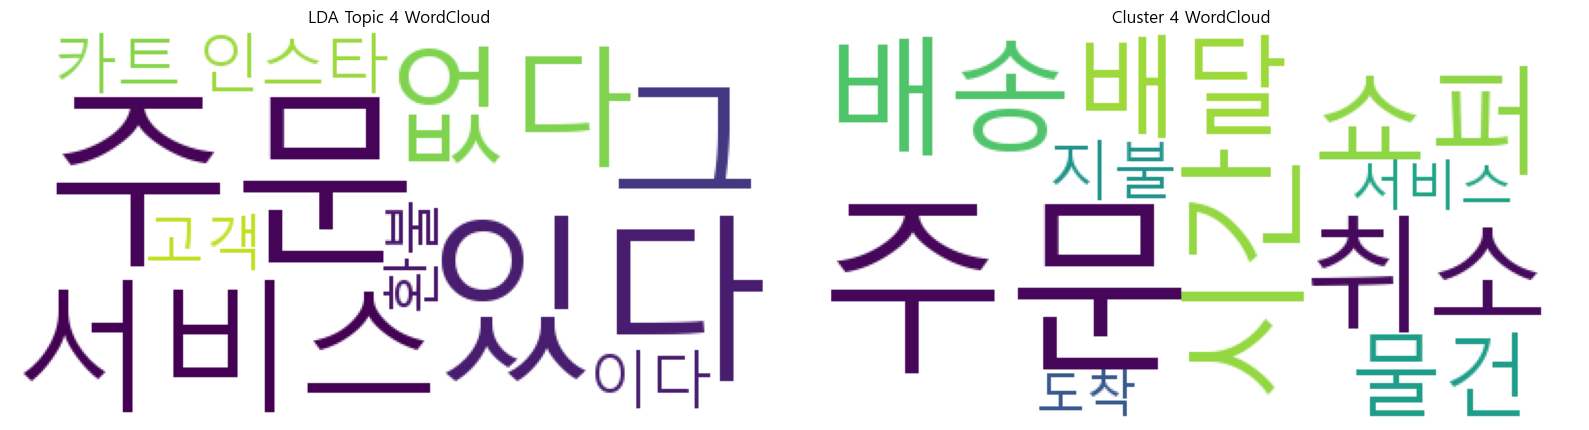

In [145]:
from wordcloud import WordCloud

# LDA WordCloud
lda_wordcloud = WordCloud(font_path="C:/Windows/Fonts/malgun.ttf", background_color="white").generate_from_frequencies(dict(lda_keywords))

# Cluster WordCloud
cluster_word_freq = {terms[i]: mean_tfidf_c4[i] for i in top_idx_c4}
cluster_wordcloud = WordCloud(font_path="C:/Windows/Fonts/malgun.ttf", background_color="white").generate_from_frequencies(cluster_word_freq)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].imshow(lda_wordcloud)
axes[0].axis("off")
axes[0].set_title("LDA Topic 4 WordCloud")

axes[1].imshow(cluster_wordcloud)
axes[1].axis("off")
axes[1].set_title("Cluster 4 WordCloud")

plt.tight_layout()
plt.show()


-> 토픽 4로 한번 비교해볼려고 한거에요 ! (위에도 마찬가지)
-> 이렇게 비교해서 보니까 LDA보다 TF-IDF가 더 키워드별로는 잘되긴했는데
- 당연함 LDA는 형용사를 집어넣었고 Cluster사용할건 명사만 넣었으니까,,ㅎ
- 이렇게 말한것 처럼 이걸 비교해서 확인한 이상,,, 조금 더 디벨롭을 ,,,,

In [148]:
# 토픽별로 리뷰 텍스트 합칠거임
df_filtered['lda_doc'] = df_filtered['tokens_LDA'].apply(lambda x: ' '.join(x))

In [149]:
# 상위 키워드 추출할거임 
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF-IDF 벡터화 전체 수행
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df_filtered['lda_doc'])
terms = vectorizer.get_feature_names_out()

# 결과 저장용 딕셔너리
topic_tfidf_keywords = {}

# 각 토픽별 상위 키워드 추출
for topic_id in sorted(df_filtered['topic_cluster'].unique()):
    # 해당 토픽에 속한 문서 인덱스
    idx = df_filtered['topic_cluster'] == topic_id
    X_topic = X_tfidf[idx]

    # 평균 벡터 → 상위 TF-IDF 키워드
    mean_tfidf = X_topic.mean(axis=0).A1
    top_idx = mean_tfidf.argsort()[::-1][:10]
    keywords = [terms[i] for i in top_idx]

    topic_tfidf_keywords[topic_id] = keywords


In [150]:
for topic_id, keywords in topic_tfidf_keywords.items():
    print(f" Topic {topic_id} 주요 키워드 (TF-IDF 기반 요약):")
    print("   " + ", ".join(keywords))


 Topic 0 주요 키워드 (TF-IDF 기반 요약):
   없다, 주문, 있다, 사용, 이다, 고객, 서비스, 다시, 문제, 이메일
 Topic 1 주요 키워드 (TF-IDF 기반 요약):
   있다, 좋다, 주문, 사용, 없다, 카트, 인스타, 쇼퍼, 이다, 서비스
 Topic 2 주요 키워드 (TF-IDF 기반 요약):
   있다, 없다, 이다, 그것, 서비스, 고객, 카트, 인스타, 멤버십, 가입
 Topic 3 주요 키워드 (TF-IDF 기반 요약):
   주문, 있다, 상품, 쇼퍼, 없다, 인스타, 카트, 선택, 시작, 사용
 Topic 4 주요 키워드 (TF-IDF 기반 요약):
   주문, 있다, 서비스, 없다, 이다, 고객, 카트, 인스타, 환불, 청구


-> 이렇게 보니까 또,,, LDA가 나은거 같기도하고,,,, 

In [152]:
df_filtered.head(2)

,rating,review,리뷰,sentences,tokens,tokens_LDA,tokens_cluster,impact_category,topic_cluster,tokens_lda,topic_label,cluster_doc,cluster,lda_doc
0,1,The two times I have ordered and had my delive...,내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다. 어떤 이...,내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다,"[내, 주문, 배달, 사무실, 두, 번의, 경험, 모두, 문제, 있다]","[내, 주문, 배달, 사무실, 두, 번의, 경험, 모두, 문제, 있다]","[주문, 배달, 사무실, 번의, 경험, 모두, 문제, 이유, 매핑, 운전자, 다른,...",배송 문제,4,"[주문, 배달, 사무실, 두, 번의, 경험, 모두, 문제, 어떻다, 이유, 인하다,...",앱/서비스 오류 및 사용성 문제,주문 배달 사무실 번의 경험 모두 문제 이유 매핑 운전자 다른 도시 운전자 메시지 ...,1,내 주문 배달 사무실 두 번의 경험 모두 문제 있다
0,1,The two times I have ordered and had my delive...,내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다. 어떤 이...,어떤 이유로 인해 앱의 매핑이 운전자를 완전히 다른 도시로 보냈습니다,"[어떻다, 이유, 인하다, 앱, 매핑, 운전자, 완전하다, 다른, 도시]","[어떻다, 이유, 인하다, 앱, 매핑, 운전자, 완전하다, 다른, 도시]","[주문, 배달, 사무실, 번의, 경험, 모두, 문제, 이유, 매핑, 운전자, 다른,...",대체품 문제,4,"[주문, 배달, 사무실, 두, 번의, 경험, 모두, 문제, 어떻다, 이유, 인하다,...",앱/서비스 오류 및 사용성 문제,주문 배달 사무실 번의 경험 모두 문제 이유 매핑 운전자 다른 도시 운전자 메시지 ...,1,어떻다 이유 인하다 앱 매핑 운전자 완전하다 다른 도시


In [153]:
# review 컬럼 제거
df_save = df_filtered.drop(columns=['review'])

# 저장
df_save.to_csv("LDA_Cluster_최종정리_0625.csv", encoding="utf-8-sig", index=False)
